In [2]:
# load in entity_const.csv into a df
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

entity_const = pd.read_csv('../data/entity_const.csv')

MP_geometry = pd.read_csv('../data/MP_geometry.csv')
MP_geometry = gpd.GeoDataFrame(MP_geometry)
MP_geometry['geometry'] = gpd.GeoSeries.from_wkt(MP_geometry['geometry'])


# load questions
questions = pd.read_csv('../data/questions.csv')
questions.columns

Index(['question', 'qnum', 'person', 'wikidataperson', 'text', 'date'], dtype='object')

In [3]:
"""Join the question entity with the MP who asked the question and their constituency"""

# a question was asked about this constituency by this MP who is from this place and has this area.


# merge the geometry of the MPs constituency with the entity in the question and the entity's constituency
joined_df = pd.merge(
            # merge the constituencies of entities with the specific question asking it
            # I have done this to get the MP who asked the question
            pd.merge(
                entity_const, questions, how="left", right_on="question", left_on="question"
                ), 
                
                MP_geometry, how="left", left_on="wikidataperson", right_on="person")




joined_df= joined_df[["question", "const_x", "personLabel", "constLabel", "geometry"]]

joined_df.rename(columns={"const_x":"question_const", "personLabel":"MP", "constLabel":"MP_const", "geometry":"MP_const_geometry"}, inplace=True)
joined_df

,question,question_const,MP,MP_const,MP_const_geometry
0,https://id.parliament.uk/wne3Q3kQ,South Staffordshire,Steve McCabe,Birmingham Selly Oak,"POLYGON ((402823.398 282975.698, 402819.399 28..."
1,https://id.parliament.uk/Q0uNVDhz,Slough,Tanmanjeet Singh Dhesi,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17..."
2,https://id.parliament.uk/oHeIeP9G,Redcar,Rachael Maskell,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45..."
3,https://id.parliament.uk/W7K6780e,Feltham and Heston,Ruth Cadbury,Brentford and Isleworth,"POLYGON ((521351.824 179500.313, 521353.700 17..."
4,https://id.parliament.uk/e9R3Yc8s,Buckingham,Julian Knight,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28..."
...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth South,Stephen Morgan,Portsmouth South,"MULTIPOLYGON (((463418.899 101737.297, 464118...."
2581,https://id.parliament.uk/51DqbupU,Tooting,Rosena Allin-Khan,Tooting,"POLYGON ((525760.499 174242.503, 525769.000 17..."
2582,https://id.parliament.uk/c7mhUeV3,North Antrim,Andrew Rosindell,Romford,"POLYGON ((548106.898 193800.904, 548224.704 19..."
2583,https://id.parliament.uk/Py4BvdeG,Cities of London and Westminster,Emily Thornberry,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18..."


In [4]:
"""Number of questions that include each constituency"""

# group the questions by the constituency asked about
# we can get a count of how many entity mentions per constituency
const_occurences = pd.DataFrame(
                    # drop multiple mentions of the same constituency in the same question
                    joined_df.drop_duplicates(subset=["question", "question_const"])
                    .groupby("question_const")["question"]
                    .count()
                    ).reset_index()
const_occurences.rename(columns={"question": "occurrences"}, inplace=True)

const_occurences = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), const_occurences, left_on="constLabel", right_on="question_const", how="left")
const_occurences.drop(columns=["question_const"], inplace=True)
const_occurences.fillna(0, inplace=True)


const_occurences = gpd.GeoDataFrame(const_occurences)

# set the geometry column
const_occurences = const_occurences.set_geometry("geometry")

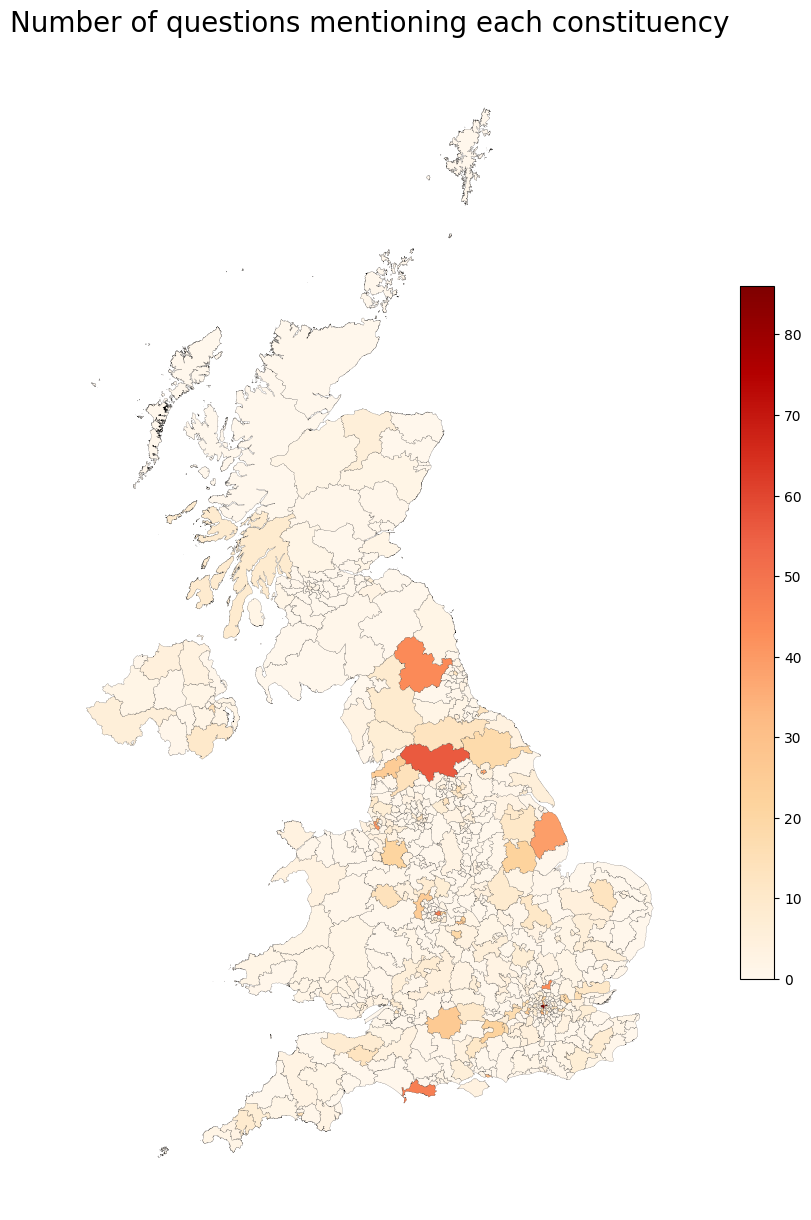

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))


const_occurences.plot(ax=ax, column="occurrences", legend=True, cmap="OrRd" , edgecolor="black", linewidth=0.1, legend_kwds={"shrink":0.6})
plt.title("Number of questions mentioning each constituency", fontsize=20)
ax.set_axis_off()

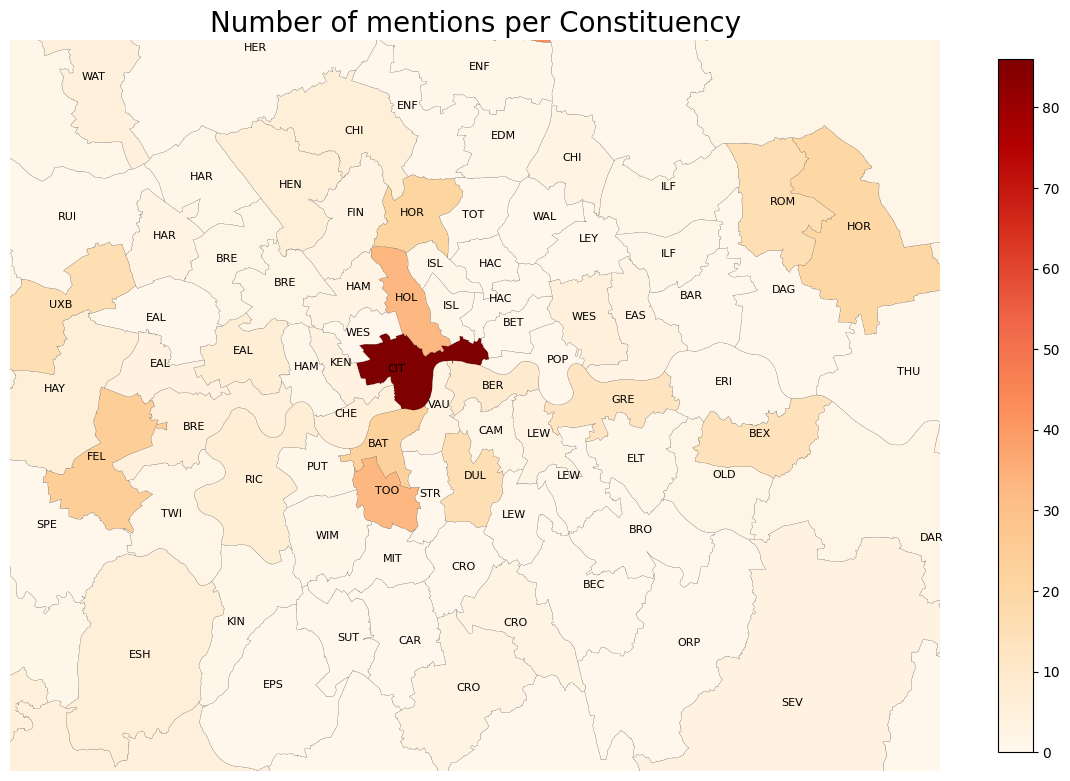

In [6]:
# plots the number of mentions and limits the axes to inside London

fig, ax = plt.subplots(figsize=(15, 15))

const_occurences.plot(ax=ax, column="occurrences", legend=True, cmap="OrRd" , edgecolor="black", linewidth=0.1, legend_kwds={'shrink':0.6})


# help to annotate the shapes https://stackoverflow.com/questions/38899190/geopandas-label-polygons 

# produce coordinates inside the polygon geometries to place the labels
const_occurences["coords"] = const_occurences["geometry"].apply(lambda x: x.representative_point().coords[:])
const_occurences["coords"] = [coords[0] for coords in const_occurences["coords"]]

for index, row in const_occurences.iterrows():
    plt.annotate(text=row["constLabel"][:3].upper(), xy=row["coords"], horizontalalignment='center', fontsize=8)

plt.title("Number of mentions per Constituency", fontsize=20)

# limit the axes to inside London
ax.set_ylim(156_000, 200_000)
ax.set_xlim(505_000, 561_000)
ax.set_axis_off()

In [60]:
"""
Number of questions made by MPs about their own constituency

"""

In [61]:
# take all entities mentioned by MPs about their own constituency
joined_df["same_const"] = joined_df["question_const"] == joined_df["MP_const"]

same_const = joined_df[joined_df["same_const"]]

# take each question by the MP that metions their constituency (by removing duplicates, where it is referenced multiple times in a question)
same_const = same_const.drop_duplicates(subset=["question"])
same_const = same_const.groupby("MP_const")["same_const"].count().reset_index()

# add geometries back for all constituencies
same_const = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), same_const, left_on="constLabel", right_on="MP_const", how="left")
same_const.drop(columns="MP_const", inplace=True)
same_const = same_const.set_geometry("geometry")

question_counts = pd.merge(questions, MP_geometry[["person", "constLabel"]], left_on="wikidataperson", right_on="person").groupby(["constLabel"])["question"].count().reset_index()
question_counts.rename(columns={"question": "total_questions"}, inplace=True)

# fill in na for constituencies that have total questions greater than 0 for their same_const value
same_const = pd.merge(same_const, question_counts, on="constLabel", how="left")
same_const[~same_const["total_questions"].isna()] = same_const[~same_const["total_questions"].isna()].fillna(0)

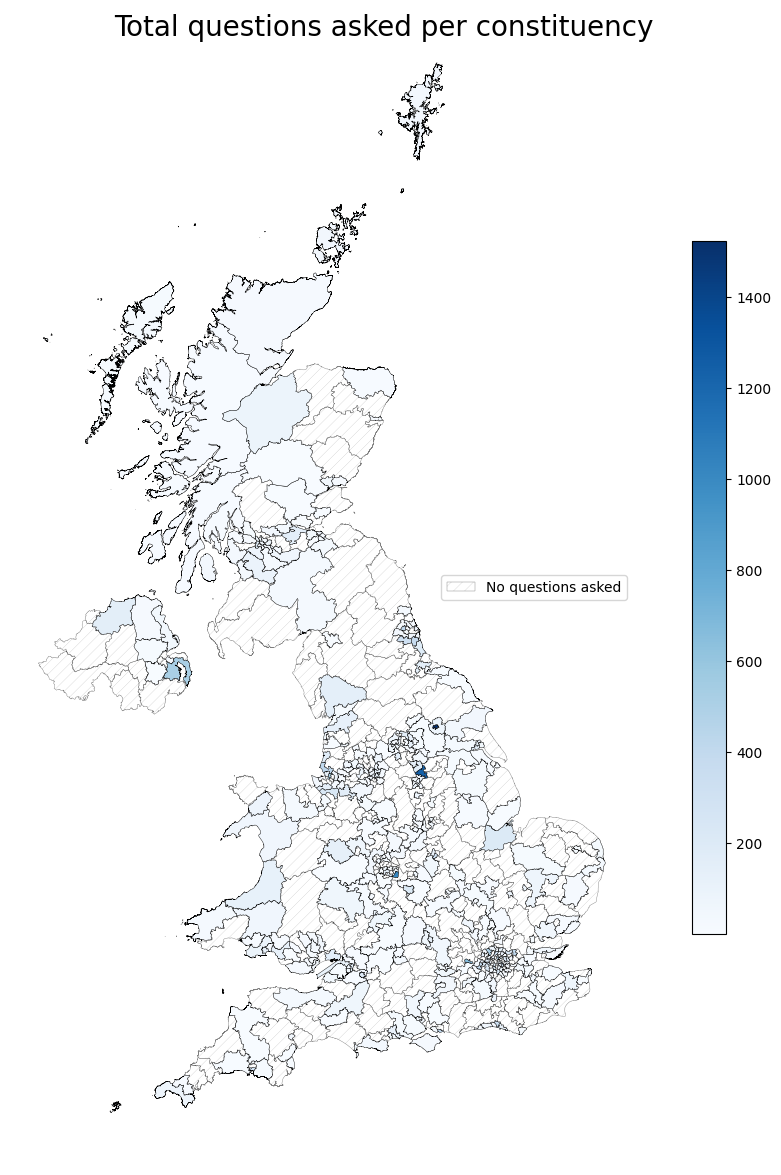

In [49]:
# help to make the second legend from
# https://stackoverflow.com/questions/57067623/geopandas-plotting-with-legend-filled-up-with-slash-lines
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(15, 15))


same_const.plot(ax=ax, column="total_questions", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3,
                missing_kwds={
                    "color" : "white",
                    "edgecolor" : "black",
                    "linewidth" : 0.3,
                    "hatch" : "///",
                    "alpha" : 0.5
                },
                
                legend_kwds={"shrink":0.6},
                ) 

LegendElement = [
                 mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='No questions asked', linewidth=0.3, alpha=0.5),
                ]
ax.legend(handles=LegendElement,loc='right')


plt.title("Total questions asked per constituency", fontsize=20, x=0.6, y=0.97 )

ax.set_axis_off()
plt.rcParams['hatch.linewidth'] = 0.1


plt.savefig("../visualisations/total_question_asked.png", dpi=300, bbox_inches="tight")


Text(0.5, 1.0, 'Cumulative proportion of questions\n asked per constituency')

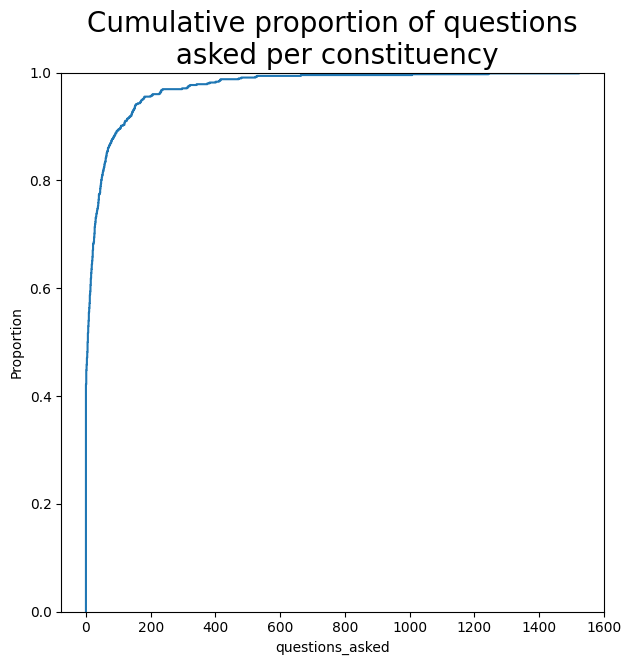

In [12]:
total_questions = same_const[["total_questions"]].sort_values(by="total_questions", ascending=False)
total_questions.fillna(0, inplace=True)
total_questions.rename(columns={"total_questions": "questions_asked"}, inplace=True)
fig, ax = plt.subplots(figsize=(7, 7))
sns.ecdfplot(data=total_questions, x="questions_asked", stat="proportion", ax=ax)
plt.title("Cumulative proportion of questions\n asked per constituency", fontsize=20)

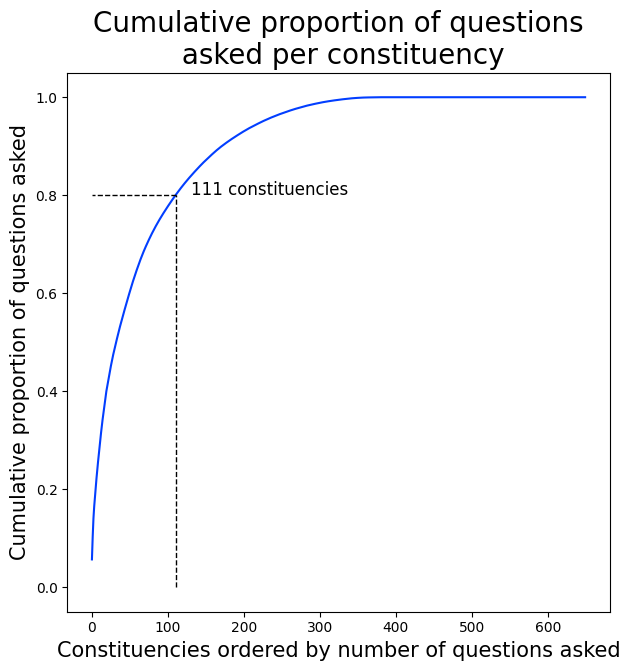

In [63]:

total_questions.sort_values(by="questions_asked", ascending=False)
total_questions.reset_index(inplace=True, drop=True)


total_questions["cumulative"] = total_questions["questions_asked"].cumsum()
total_questions["cumulative_proportion"] = total_questions["cumulative"] / total_questions["cumulative"].max()

fig, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=range(len(total_questions)), y="cumulative_proportion", data=total_questions)

# plot pareto lines
first_80_row = total_questions[total_questions["cumulative_proportion"] > 0.8].head(1)
ax.plot([first_80_row.index[0] + 1, first_80_row.index[0] + 1], [0, 0.8] , color="black", linestyle="dashed", linewidth=1)
ax.plot([first_80_row.index[0] + 1, 0], [0.8, 0.8], color="black", linestyle="dashed", linewidth=1)
ax.text(first_80_row.index[0] + 20, 0.8, f"{first_80_row.index[0] + 1} constituencies", fontsize=12)


ax.set_xlabel("Constituencies ordered by number of questions asked", fontsize=15)
ax.set_ylabel("Cumulative proportion of questions asked", fontsize=15)
ax.set_title("Cumulative proportion of questions\n asked per constituency", fontsize=20)
plt.savefig("../visualisations/cumulative_proportion_questions_asked.png", dpi=300, bbox_inches="tight")



In [64]:
total_questions[total_questions["cumulative_proportion"] >0.8].head(1)

,questions_asked,cumulative,cumulative_proportion
110,58.0,21493.0,0.800037


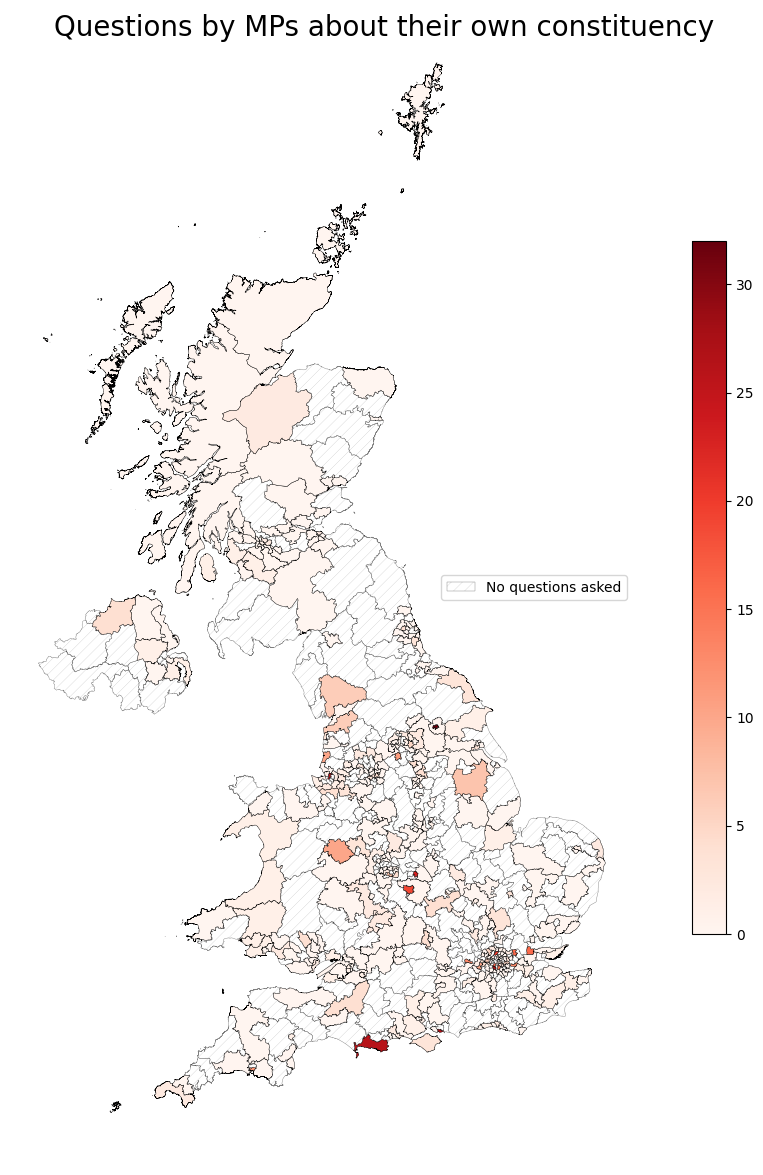

In [37]:
# help to make the second legend from
# https://stackoverflow.com/questions/57067623/geopandas-plotting-with-legend-filled-up-with-slash-lines

fig, ax = plt.subplots(figsize=(15, 15))


same_const.plot(ax=ax, column="same_const", legend=True, cmap="Reds", edgecolor="black", linewidth=0.3,
                missing_kwds={
                    "color" : "white",
                    "edgecolor" : "black",
                    "linewidth" : 0.3,
                    "hatch" : "///",
                    "alpha" : 0.5
                },                
                
                 legend_kwds={"shrink":0.6}) #cmap="OrRd"

LegendElement = [
                 mpatches.Patch(facecolor="white", edgecolor="black", hatch="///", label="No questions asked", linewidth=0.3, alpha=0.5),
                ]
ax.legend(handles=LegendElement,loc='right')
plt.title("Questions by MPs about their own constituency", fontsize=20, x=0.6, y=0.97)

ax.set_axis_off()
plt.rcParams['hatch.linewidth'] = 0.1
plt.savefig("../visualisations/questions_constituency_focussed.png", dpi=300, bbox_inches="tight")


Text(0.5, 1.0, 'Cumulative proportion of questions asked\n by MPs about their own constituency')

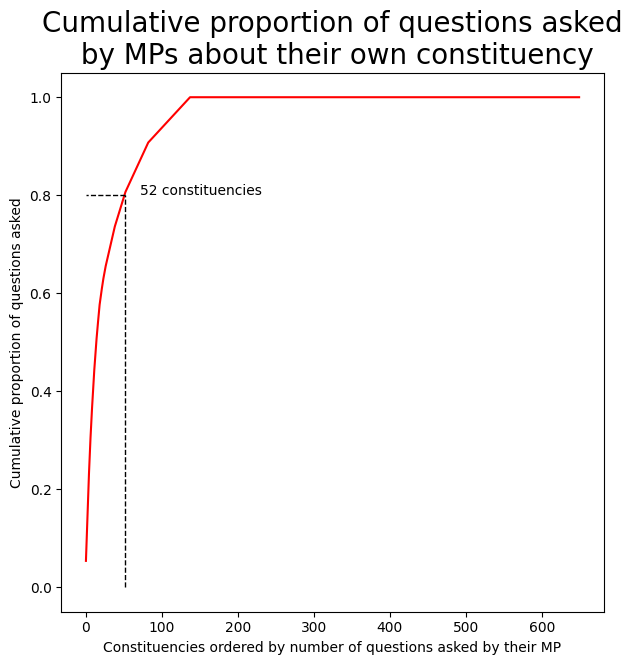

In [16]:
total_same_const = same_const[["same_const"]]
total_same_const = total_same_const.fillna(0)
total_same_const.sort_values(by="same_const", ascending=False, inplace=True)
total_same_const = total_same_const.reset_index(drop=True)

total_same_const["cumulative"] = total_same_const["same_const"].cumsum()
total_same_const["cumulative_proportion"] = total_same_const["cumulative"] / total_same_const["cumulative"].max()
total_same_const
fig, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=range(len(total_same_const)), y="cumulative_proportion", data=total_same_const, color="red")

# plot pareto lines
first_80_row = total_same_const[total_same_const["cumulative_proportion"] > 0.8].head(1)
ax.plot([first_80_row.index[0] + 1, first_80_row.index[0] + 1], [0, 0.8], color="black", linestyle="dashed", linewidth=1)
ax.plot([first_80_row.index[0] + 1, 0], [0.8, 0.8], color="black", linestyle="dashed", linewidth=1)
ax.text(first_80_row.index[0] + 20, 0.8, f"{first_80_row.index[0] + 1} constituencies", fontsize=10)

ax.set_xlabel("Constituencies ordered by number of questions asked by their MP")
ax.set_ylabel("Cumulative proportion of questions asked")
ax.set_title("Cumulative proportion of questions asked\n by MPs about their own constituency", fontsize=20)

In [65]:
questions

,question,qnum,person,wikidataperson,text,date
0,https://id.parliament.uk/0IwOO533,903422,https://id.parliament.uk/Vs3bGLNz,http://www.wikidata.org/entity/Q689287,Which three departments had the lowest proport...,2023-01-05+00:00
1,https://id.parliament.uk/dRJ9254g,117748,https://id.parliament.uk/eD0yd5Ec,http://www.wikidata.org/entity/Q19871931,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00
2,https://id.parliament.uk/e4IDRkKi,117410,https://id.parliament.uk/RlIqlixq,http://www.wikidata.org/entity/Q695228,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00
3,https://id.parliament.uk/rXZ0r1JW,117477,https://id.parliament.uk/1DzMUkBy,http://www.wikidata.org/entity/Q337812,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00
4,https://id.parliament.uk/SmC4cGhg,117777,https://id.parliament.uk/tOfis7j9,http://www.wikidata.org/entity/Q27942399,To ask the Secretary of State for Health and S...,2023-01-06+00:00
...,...,...,...,...,...,...
26860,https://id.parliament.uk/pkosM2MK,906563,https://id.parliament.uk/wSRcmnqE,http://www.wikidata.org/entity/Q20127903,What steps his Department is taking to reduce ...,2023-09-19+01:00
26861,https://id.parliament.uk/JmAZSx2y,906567,https://id.parliament.uk/Vs3bGLNz,http://www.wikidata.org/entity/Q689287,If he will take steps to expedite the approval...,2023-09-19+01:00
26862,https://id.parliament.uk/dPiUF1wi,906604,https://id.parliament.uk/Fx1EcmX5,http://www.wikidata.org/entity/Q304027,What discussions he has had with the Welsh Gov...,2023-09-19+01:00
26863,https://id.parliament.uk/dhVF7qpN,906500,https://id.parliament.uk/iqJbTPtY,http://www.wikidata.org/entity/Q1681420,"To ask the Secretary of State for Environment,...",2023-09-19+01:00


<Axes: xlabel='same_const', ylabel='Count'>

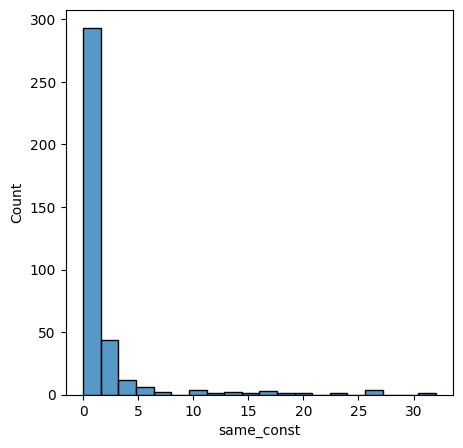

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=same_const, x="same_const", bins=20)

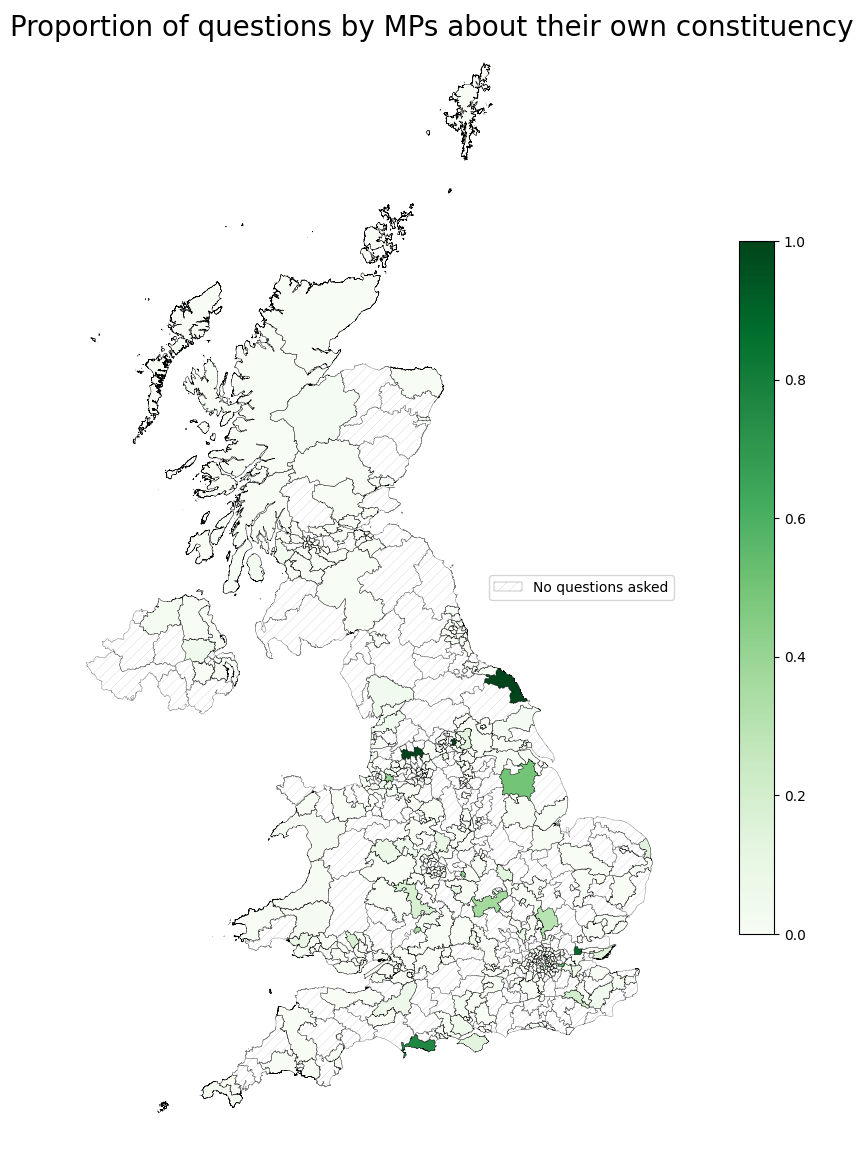

In [66]:
# help to make the second legend from
# https://stackoverflow.com/questions/57067623/geopandas-plotting-with-legend-filled-up-with-slash-lines

same_const["proportion_same_const"] = same_const["same_const"] / same_const["total_questions"]
fig, ax = plt.subplots(figsize=(15, 15))
same_const.plot(ax=ax, column="proportion_same_const", legend=True, cmap="Greens", edgecolor="black", linewidth=0.3,
                
                missing_kwds={
                    "color" : "white",
                    "edgecolor" : "black",
                    "linewidth" : 0.3,
                    "hatch" : "///",
                    "alpha" : 0.5
                }, 
                legend_kwds={"shrink":0.6},
                )

LegendElement = [
                 mpatches.Patch(facecolor="white", edgecolor="black", hatch="///", label="No questions asked", linewidth=0.3, alpha=0.5),
                ]
ax.legend(handles=LegendElement,loc="right")
ax.set_axis_off()
plt.rcParams["hatch.linewidth"] = 0.1
plt.title("Proportion of questions by MPs about their own constituency", fontsize=20, x=0.6, y=0.97)

plt.savefig("../visualisations/prop_questions_constituency_focussed.png", dpi=300, bbox_inches="tight")


<Axes: xlabel='proportion_same_const', ylabel='Count'>

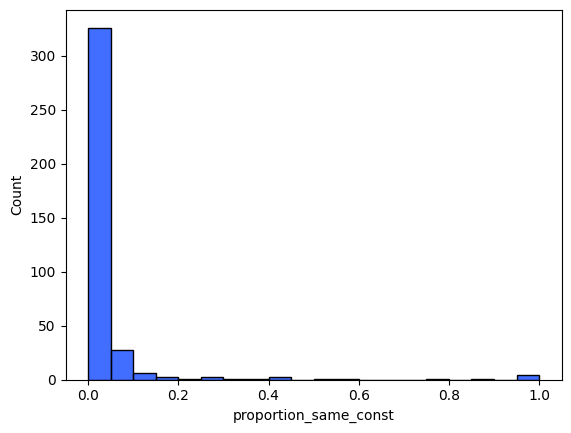

In [67]:
# graph showing the distribution of proportions of questions asked by MPs about their own constituency using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(same_const["proportion_same_const"], bins=20)

In [69]:
same_const.sort_values("total_questions", ascending=False).head(10)

,constLabel,geometry,same_const,total_questions,proportion_same_const
160,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",32.0,1524.0,0.020997
514,Wentworth and Dearne,"POLYGON ((436259.099 397360.096, 436257.599 39...",4.0,1244.0,0.003215
545,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28...",4.0,1008.0,0.003968
630,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17...",13.0,664.0,0.019578
83,Liverpool Walton,"POLYGON ((338860.901 397978.399, 338935.099 39...",27.0,529.0,0.051040
508,Strangford,"POLYGON ((166192.764 532012.369, 166196.879 53...",1.0,524.0,0.001908
444,Hendon,"POLYGON ((517435.816 194420.872, 517437.398 19...",5.0,480.0,0.010417
583,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18...",1.0,472.0,0.002119
34,Sefton Central,"POLYGON ((330283.243 398043.486, 330281.620 39...",0.0,416.0,0.000000
47,Newcastle upon Tyne Central,"POLYGON ((420660.103 563375.205, 420642.500 56...",4.0,415.0,0.009639


In [23]:
same_const.sort_values("same_const", ascending=False).head(10)

,constLabel,geometry,same_const,total_questions,proportion_same_const
160,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",32.0,1524.0,0.020997
83,Liverpool Walton,"POLYGON ((338860.901 397978.399, 338935.099 39...",27.0,529.0,0.051040
349,Portsmouth South,"MULTIPOLYGON (((463418.899 101737.297, 464118....",27.0,401.0,0.067332
477,Tooting,"POLYGON ((525760.499 174242.503, 525769.000 17...",26.0,181.0,0.143646
376,South Dorset,"POLYGON ((382017.820 95732.800, 382014.920 957...",26.0,34.0,0.764706
470,Coventry North East,"POLYGON ((434074.760 283790.550, 434074.929 28...",23.0,54.0,0.425926
209,Hornsey and Wood Green,"POLYGON ((531727.046 191669.493, 531730.749 19...",20.0,312.0,0.064103
345,Warwick and Leamington,"POLYGON ((422669.004 265347.305, 422685.197 26...",19.0,205.0,0.092683
77,Battersea,"POLYGON ((528564.154 177799.665, 528575.613 17...",17.0,237.0,0.071730
600,Romford,"POLYGON ((548106.898 193800.904, 548224.704 19...",16.0,411.0,0.038929


In [24]:
same_const.sort_values(by="total_questions", ascending=False).head(10)

,constLabel,geometry,same_const,total_questions,proportion_same_const
160,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",32.0,1524.0,0.020997
514,Wentworth and Dearne,"POLYGON ((436259.099 397360.096, 436257.599 39...",4.0,1244.0,0.003215
545,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28...",4.0,1008.0,0.003968
630,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17...",13.0,664.0,0.019578
83,Liverpool Walton,"POLYGON ((338860.901 397978.399, 338935.099 39...",27.0,529.0,0.051040
508,Strangford,"POLYGON ((166192.764 532012.369, 166196.879 53...",1.0,524.0,0.001908
444,Hendon,"POLYGON ((517435.816 194420.872, 517437.398 19...",5.0,480.0,0.010417
583,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18...",1.0,472.0,0.002119
34,Sefton Central,"POLYGON ((330283.243 398043.486, 330281.620 39...",0.0,416.0,0.000000
47,Newcastle upon Tyne Central,"POLYGON ((420660.103 563375.205, 420642.500 56...",4.0,415.0,0.009639


In [70]:
"""
SPARQL query to get the current ministers in the 58th parliment and their constituencies
"""


# help from https://rebeccabilbro.github.io/sparql-from-python/
# also from https://stackoverflow.com/questions/51673685/how-to-show-or-filter-by-qualifier
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

question_df = pd.DataFrame()
sparql  = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setQuery("""


SELECT ?person ?const ?personLabel ?constLabel ?ministerPositionLabel
WHERE
{
  # gets members of the 58th parliment and their constituency
  ?person p:P39 ?position.
  ?position ps:P39 wd:Q77685926.
  ?position pq:P768 ?const.
  
  # gets people who hold a ministerial position
  ?person wdt:P39 ?ministerPosition.
  ?ministerPosition wdt:P361 wd:Q112014.
  
  # gets the node for the position, so I can later check the end time qualifier
  ?person p:P39 ?positionStatement.
  ?positionStatement ps:P39 ?ministerPosition. 

  FILTER (
    NOT EXISTS { ?positionStatement pq:P582 ?dateEnded. } # no end date, so still have this role
    ||
    EXISTS { 
      ?positionStatement pq:P582 ?dateEnded.
      FILTER (?dateEnded >= "2023-01-01+00:00"^^xsd:dateTime) # end date that is within the time period of the questions
    }
  )
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  
}
""")

sparql.setReturnFormat(JSON)
result = sparql.query().convert()
# results -> bindings returns a list of dictionaries
result = result["results"]["bindings"]

# removed type from the results
for item in result:
    for key in item:
        item[key] = item[key]["value"]

In [71]:
cabinet_MPs = pd.DataFrame(result)
cabinet_MPs.drop_duplicates(subset=["constLabel"], inplace=True)
len(cabinet_MPs)

38

In [72]:
len(cabinet_MPs["personLabel"].unique())

38

In [73]:
# get a df of the constituencies of the cabinet ministers
cabinet_constituencies = same_const[same_const["constLabel"].isin(list(cabinet_MPs["constLabel"].unique()))]
cabinet_constituencies.sort_values("total_questions", ascending=False)

,constLabel,geometry,same_const,total_questions,proportion_same_const
313,Tatton,"POLYGON ((371724.899 387929.696, 371741.199 38...",0.0,45.0,0.000000
302,Norwich North,"MULTIPOLYGON (((619850.003 310507.198, 619823....",1.0,15.0,0.066667
579,Esher and Walton,"POLYGON ((512535.701 168963.404, 512560.197 16...",0.0,3.0,0.000000
2,Dumfries and Galloway,"MULTIPOLYGON (((266001.597 603288.500, 266016....",NaN,NaN,NaN
17,North West Durham,"POLYGON ((419489.254 556877.150, 419365.002 55...",NaN,NaN,NaN
24,Wyre and Preston North,"POLYGON ((334436.943 444632.775, 334398.488 44...",NaN,NaN,NaN
63,Braintree,"POLYGON ((564926.600 243518.903, 564944.896 24...",NaN,NaN,NaN
71,Cheltenham,"POLYGON ((399393.403 222708.400, 399382.503 22...",NaN,NaN,NaN
120,Surrey Heath,"POLYGON ((496215.798 166832.904, 496250.502 16...",NaN,NaN,NaN
154,Fareham,"POLYGON ((451762.197 111202.398, 451748.700 11...",NaN,NaN,NaN


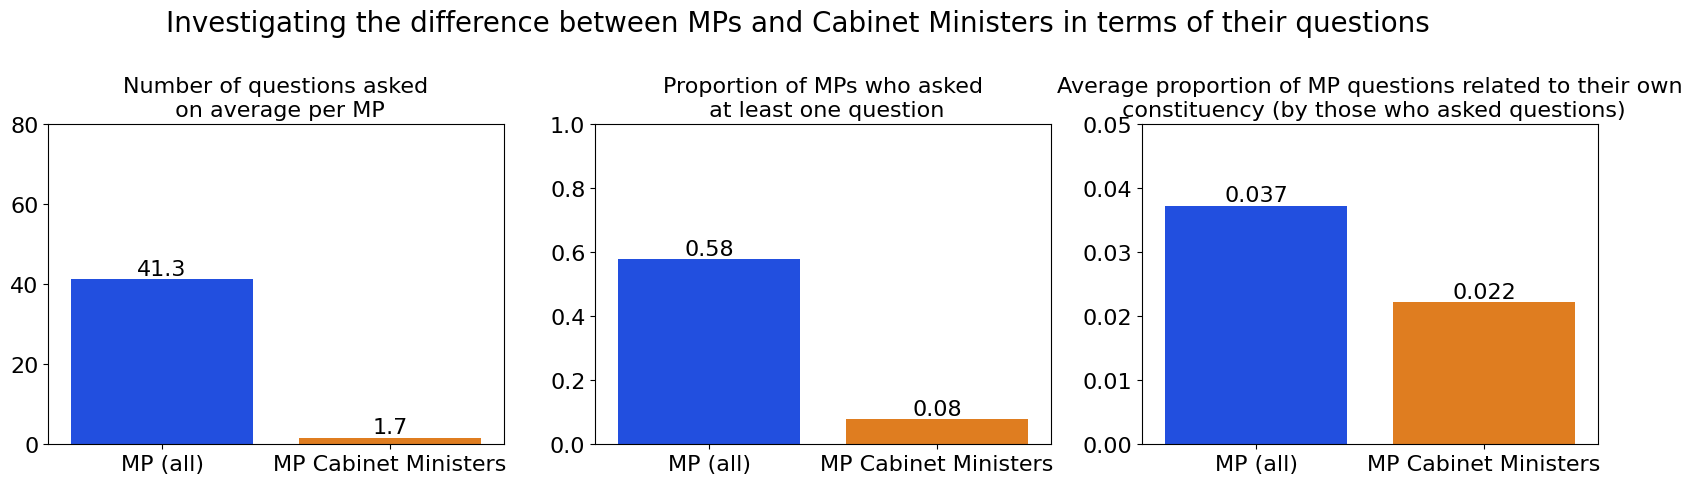

In [92]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=3)

plt.subplots_adjust(wspace=0.2)

sns.set_palette("bright")

sns.barplot(x=["MP (all)"], y=[same_const["total_questions"].fillna(0).mean()], ax=axs[0])
sns.barplot(x=["MP Cabinet Ministers"], y=[cabinet_constituencies["total_questions"].fillna(0).mean()], ax=axs[0])
axs[0].set_title("Number of questions asked\n on average per MP", fontsize=16)
axs[0].set_ylim(0, 80)
axs[0].tick_params(axis="both", labelsize=16)

sns.barplot(x=["MP (all)"], y=[(~same_const["total_questions"].isna()).sum()/len(same_const)], ax=axs[1])
sns.barplot(x=["MP Cabinet Ministers"], y=[(~cabinet_constituencies["proportion_same_const"].isna()).sum()/len(cabinet_constituencies)], ax=axs[1])
axs[1].set_title("Proportion of MPs who asked\n at least one question", fontsize=16)
axs[1].set_ylim(0, 1)
axs[1].tick_params(axis="both", labelsize=16)

sns.barplot(x=["MP (all)"], y=[same_const["proportion_same_const"].mean()], ax=axs[2])
sns.barplot(x=["MP Cabinet Ministers"], y=[cabinet_constituencies["proportion_same_const"].mean()], ax=axs[2])
axs[2].set_title("Average proportion of MP questions related to their own\n constituency (by those who asked questions)", fontsize=16)
axs[2].set_ylim(0, 0.05)
axs[2].tick_params(axis="both", labelsize=16)

fig.suptitle("Investigating the difference between MPs and Cabinet Ministers in terms of their questions", fontsize=20)
fig.subplots_adjust(top=0.75)


fmts = ["%.1f", "%.2f", "%.3f"]
for y, ax in enumerate(axs):
    for i in range(2):
        ax.bar_label(ax.containers[i], fmt=fmts[y], label_type="edge", fontsize=16)



plt.savefig("../visualisations/cabinet_ministers.png", dpi=300, bbox_inches="tight")
